## PyTorch 학습 레벨 2 - 002
---

### 순서
1. _~~Tensor를 사용한 신경망~~_
2. torch.nn.functional 사용하기
3. optm을 이용하여 리팩토링 하기
4. fit() 와 get_data() 생성하기
5. CNN 으로 넘어가기

### Tensor를 사용한 신경망
- 신경망 구축
    - FashionMNIST 분류기(입력: 784, 출력: 10)
    - 가중치와 편향을 가지는 선형모델
    - 활성화 함수 : log softmax
    - 손실 함수 : negative log-likelihood
    - 평가 지표 : accuracy
    - training loop에서는 아래의 동작을 수행
        - 데이터에서 배치(64)를 선택 `DataLoader` 사용
        - 모델을 이용하여 예측 수행
        - 손실 계산
        - `backward()`를 이용하여 모델의 weight, bias 기울기 업데이트

#### 데이터 준비
- [FashionMNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist) 데이터셋을 다운로드
- `TorchVison` 직접사용과 달리, 데이터셋 다운로드 후 이를 직접 정의한 `CustomDataset` 사용
- `data`폴더에 다운로드, `wget` 패키지로 다운로드
- FashionMNIST 데이터셋은 60000개의 학습용 데이터와 100000개의 테스트용 데이터로 구분
- 학습용 데이터 중 10%(6000개)를 validation set으로 분리

In [1]:
# wget 모듈 설치
!pip install wget

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=4345481ca77264bbe59756f56ed3795044f25995254485ced2f720ed89ceea1f
  Stored in directory: c:\users\perso\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [6]:
from sklearn.model_selection import train_test_split
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import math
import time

# device = torch.device('cpu')
device = torch.device('cuda')

In [2]:
import wget

In [3]:
urls = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz']

for url in urls:
    # data 폴더 하위에 url에 게재되어 있는 자료를 다운도르 받는다 
    wget.download(url, './data')

In [8]:
# code source : https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
# gz 파일을 열어 이미지와 라벨을 읽어들여 반환
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
        labels = labels.astype(np.int64)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images/255.0, labels


x_train, y_train = load_mnist('data', kind='train')
# sckit-learn의 train_test_split() 함수가 데이터 분리시 가장 편리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
x_test, y_test = load_mnist('data', kind='t10k')

print(f'train : image{x_train.shape}/{type(x_train[0])}, label{y_train.shape}/{type(y_train[0])}')
print(f'valid : image{x_val.shape}/{type(x_val[0])}, label{y_val.shape}/{type(y_val[0])}')
print(f'test  : image{x_test.shape}/{type(x_test[0])}, label{y_test.shape}/{type(y_test[0])}')

train : image(54000, 784)/<class 'numpy.ndarray'>, label(54000,)/<class 'numpy.int64'>
valid : image(6000, 784)/<class 'numpy.ndarray'>, label(6000,)/<class 'numpy.int64'>
test  : image(10000, 784)/<class 'numpy.ndarray'>, label(10000,)/<class 'numpy.int64'>


#### 커스텀 데이터셋/데이터로더 정의
- lbl203_*.ipynb에 정의한 CustomImageDataset과 차이 있음
- 커스텀 데이터셋에서는 `__init__`, `__len__`, `__getitem__`을 정의해야 하면 각 메서드에서는 다음과 같은 작업을 수행
    - `__init__` : 클래스의 멤버변수 x, y, transform, target_transform을 파라미터를 이용하여 초기화. x는 image 데이터/y는 라벨/transform은 이미지에 적용 될 transform/target_transform은 라벨에 적용 될 transform을 의미
    - `__len__` : 데이터셋의 샘플 개수를 반환
    - `__getitem__` : 주어진 인덱스에 해당하는 샘플을 (image, label) 쌍으로 반환. 이때, image에는 transform을 적용하고 라벨에는 target_transform을 적용하여 반환


In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        self.labels = ['T-Shirt',  'Trouser', 'Pullover', 'Dress', 'Coat', 
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
        
        self.x = x # 이미지
        self.y = y # 라벨
        self.transform = transform # 이미지에 적용 될 transform
        self.target_transform = target_transform # 라벨에 적용 될 transform

    def __len__(self):
        return len(self.y) # 데이터셋의 샘플 개수

    def __getitem__(self, idx): # 주어진 idx번째에 해당하는 샘플을 반환
        img = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(img)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

- training loop에서는 배치를 선택하는 구간이 존재. 이를 수월하기 진행하기 위하여 위에서 `DataLoader`를 이용
- `DataLoader` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate) 가능. 
    - 아래의 각 순회(iteration)는 (각각 `batch_size=64` 의 특징(feature)과 정답(label)을 포함하는) `train_features` 와 `train_labels` 의 묶음(batch)을 반환
    - `shuffle=True` 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞임. 
    - (데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) 를 참조)

In [12]:
train_ds = CustomImageDataset(x_train, y_train, 
                              transform=torch.Tensor)
val_ds = CustomImageDataset(x_val, y_val, 
                            transform=torch.Tensor)

x_test = torch.Tensor(x_test).to(device)
y_test = torch.from_numpy(y_test).to(device) # from_numpy() : np.array를 tensor로 변환

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

train_dl, val_dl

(<torch.utils.data.dataloader.DataLoader at 0x1fb41eca250>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb41db0e50>)

##### 정상생성 확인

In [13]:
def get_label_name(label): # 라벨(숫자)를 입력받아 해당 라벨의 의미를 반환
    LABLE_NAMES = ['T-Shirt',  'Trouser', 'Pullover', 'Dress', 'Coat', 
                    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
    return LABLE_NAMES[label]

In [14]:
def show_batch(features, labels):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, 65):
        img = features[i-1]
        label = get_label_name(labels[i-1])
        ax = fig.add_subplot(8, 8, i)
        
        
        if device.type  == 'cuda':
            img = img.cpu()
        ax.imshow(img.reshape(28,28), cmap='gray_r')
        ax.set_title(label)
        ax.set_xticks([]), ax.set_yticks([])

    plt.tight_layout()
    plt.show()

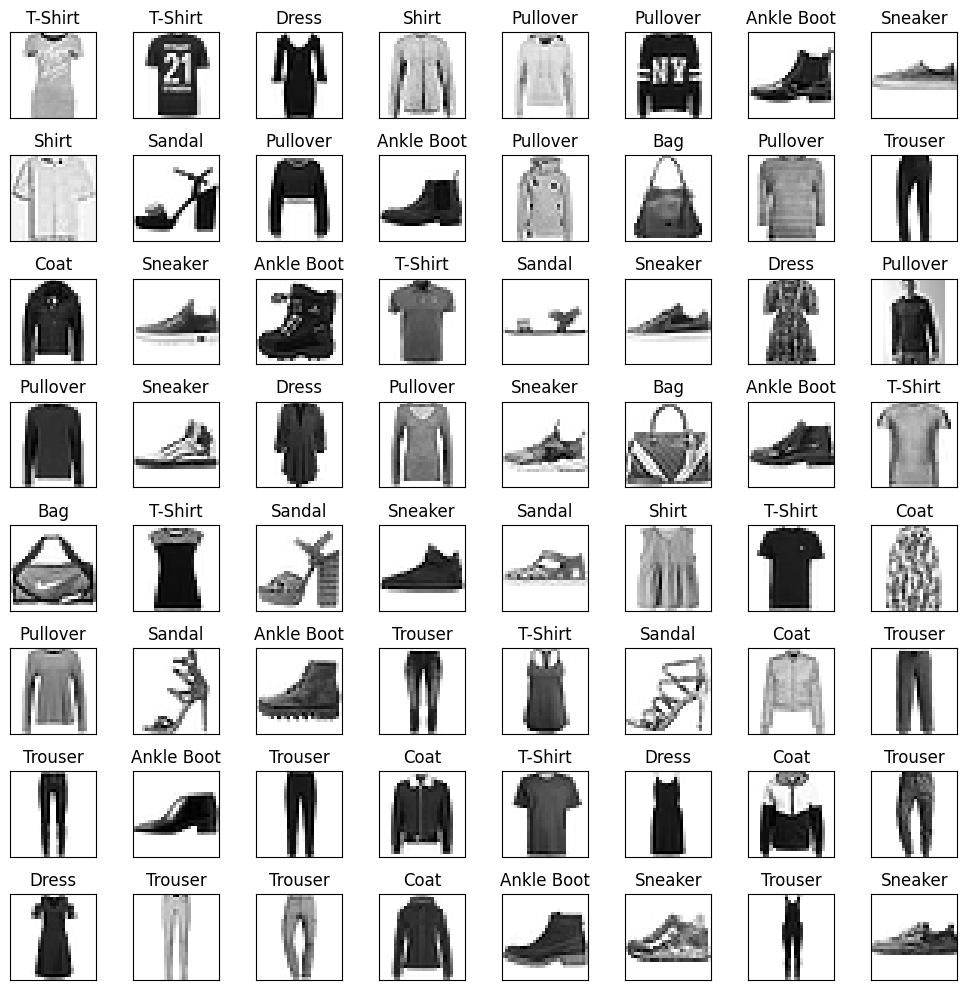

In [15]:
features, labels = next(iter(train_dl))
features, labels = features.to(device), labels.to(device)
show_batch(features, labels)

#### 신경망 정의

##### 가중치
- 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메서드를 제공, 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 예정
- 우리는 PyTorch에게 이들이 기울기(gradient)가 필요하다고 알려줌
- 이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록, *자동적으로* 역전파(back-propagation) 동안에 기울기를 계산할 수 있음
- 가중치에 대해서는 `requires_grad_` 를 초기화(initialization) **다음에** 설정. 왜냐하면 해당 단계가 기울기에 포함되는 것을 원치 않기 때문
    - (PyTorch에서 `_` 다음에 오는 메서드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미)

- [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 기법을 이용하여 가중치 초기화.
    - Standard gaussian을 이용해 생성한 난수를 '입력의 수'로 나누어 스케일링. 이에 대해서는 cs231n lec6에 다뤄짐


- 입력이미지는 reshape로 28 * 28로 변경하였고, 28 x 28 = 784
- 라벨(출력) 개수는 10개 

In [16]:
weights = torch.randn(784, 10, device=device) / math.sqrt(784) # 784열 10행 크기의 평균이 0 이고 분산이 1인 정규 분포(표준 정규 분포라고도 함)의 난수로 채워진 텐서를 반환
weights.requires_grad_()
bias = torch.zeros(10, device=device, requires_grad=True)
weights, bias

(tensor([[ 0.0518, -0.0376,  0.0284,  ...,  0.0042,  0.0206,  0.0386],
         [ 0.0123,  0.0097, -0.0397,  ..., -0.0786,  0.0160, -0.0217],
         [ 0.0158, -0.0038,  0.0196,  ..., -0.0197, -0.0089, -0.0052],
         ...,
         [-0.0584, -0.0350,  0.0111,  ...,  0.0119, -0.0159,  0.0010],
         [ 0.0247, -0.0174, -0.0340,  ..., -0.0189, -0.0537,  0.0358],
         [ 0.0192, -0.0091,  0.0233,  ...,  0.0423,  0.0313, -0.0082]],
        device='cuda:0', requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
        requires_grad=True))

##### 모델 정의
- PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수(또는 호출 가능한 객체)를 모델로 사용 가능
- 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용
- 활성화 함수(activation function)가 필요하므로,`log_softmax` 를 구현하고 사용

In [17]:
# softmax 함수에 log를 취한것과 동일
# 하지만, 두 연산을 따로 수행하는 것보다 더 빠르고 수치적으로 안정적
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # unsqueeze() : 특정위치에 1인차원을 추가함

def model(xb):
    return log_softmax(xb @ weights + bias)  # 점곱(dot product) 연산

- 실제적으로 PyTorch에서는 ReLU 활성화 함수가 가장 많이 쓰임.
- log_softmax 정의를 알고 싶으면 [링크](https://discuss.pytorch.org/t/log-softmax-function-in-pytorch-tutorial-example/52041)

- `@` 기호는 점곱(dot product) 연산
- 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출

In [18]:
preds = model(features)  # 예측
print(f'preds[0] : {preds[0]}\npreds.shape : {preds.shape}')

preds[0] : tensor([-2.3342, -2.2533, -2.2830, -2.3713, -2.3438, -2.4940, -2.1083, -2.3372,
        -2.2158, -2.3322], device='cuda:0', grad_fn=<SelectBackward0>)
preds.shape : torch.Size([64, 10])


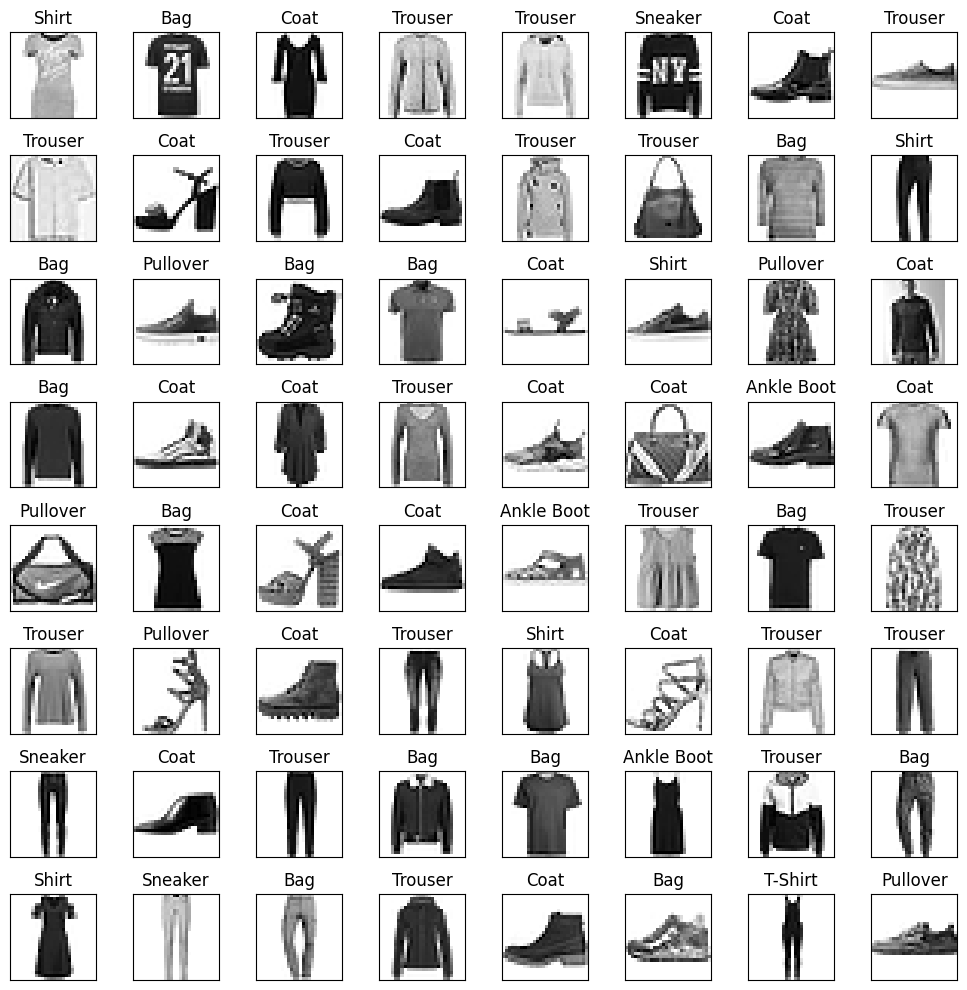

In [19]:
preds_label = torch.argmax(preds, -1)
show_batch(features, preds_label)

- 예측 결과가 엉망(!)이라는 것을 알 수 있음

#### loss

- `preds` 텐서(tensor)는 텐서 값 외에도, 기울기 함수(gradient function)를 포함.
- 나중에 이것을 역전파(backpropagation)를 위해 사용
- 손실함수 차례  `음의 로그 우도(Negative Log-Likelihood)`를 구현

- SoftMax

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/main/images/torch0021.png" width="700">

- Negative Log-Likehood(NLL)

    <img src="https://raw.githubusercontent.com/hugoMGSung/study-pytorch/main/images/torch0022.png" width="700">